In [ ]:
import pandas as pd

In [ ]:
try:
    df_imdb = pd.read_csv("imdb_top_1000.csv")
    print('Dataset cargado con éxito.')    
except FileNotFoundError:
    print(f"No se encontró el archivo. Verifica la ruta e intenta de nuevo.")

# Primeras 5 filas del dataset
df_imdb.head()



In [ ]:
# Cantidad de filas y columnas del dataset
df_imdb.shape



In [ ]:
# Tipo de datos por columnas
df_imdb.info()



In [ ]:
# Muestra estadística por las columnas numéricas
df_imdb.describe()



In [ ]:
# Cantidad de valores únicos por columnas
for col in df_imdb:
    print(f"{col}: {df_imdb[col].nunique()} únicos")
# Certificate es la más categórica

In [ ]:
# Valores nulos por columna
print(df_imdb.isnull().sum())

In [ ]:
# LIMPIEZA DE DATOS

# Ajustar nombres de las columnas a minúsculas y reeplazar espacios con guiones bajos
df_imdb.columns = df_imdb.columns.str.lower().str.replace(' ', '_')

# Limpieza y conversión de Runtime a numérico
# Elimino el texto min y convierto a int
df_imdb['runtime_minutes'] = df_imdb['runtime'].str.replace(' min', '').astype(int)

# Limpieza y conversión de Released_Year 
df_imdb['released_year'] = pd.to_numeric(df_imdb['released_year'], errors='coerce').astype('Int64')

# Limpieza y conversión de Gross a numérico
df_imdb['gross'] = df_imdb['gross'].astype(str).str.replace(',', '')
df_imdb['gross'] = pd.to_numeric(df_imdb['gross'], errors='coerce')
# QUEDAN NULOS

# Manejo de nulos
df_imdb['certificate'] = df_imdb['certificate'].fillna('Unknown')
df_imdb['meta_score'] = df_imdb['meta_score'].fillna(df_imdb['meta_score'].mean())
df_imdb['gross'] = df_imdb['gross'].fillna(0)
df_imdb = df_imdb.dropna(subset='released_year')



In [ ]:
# CARGA DE DATAFRAME A SQLITE
import sqlite3

# Cargo todo a una db SQLITE para simular que la data para el análisis proviene de una Base de Datos
db_file = 'db/imdb.db'

try:
    conn = sqlite3.connect(db_file)
    print(f"Conexión a la base de datos '{db_file}' establecida exitosamente.")

except sqlite3.Error as e:
    print(f"Error al conectar a la base de datos: {e}")
    
# Nombre de la tabla a la que se cargará el df
table_name = 'imdb_movies_clean'

# Cargo el df a SQLite

try:
    df_imdb.to_sql(table_name, conn, if_exists='replace', index=False)
    print(f"DataFrame cargado a la tabla '{table_name}' exitosamente.")
except Exception as e:
    print(f"Error al cargar el DataFrame a la base de datos: {e}")


In [ ]:
# PREPARACIÓN PARA EL EDA Y VISUALIZACIÓN

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuración básica para los gráficos
sns.set_style("whitegrid") # Estilo de fondo para Seaborn
plt.rcParams['figure.figsize'] = (10, 6) # Tamaño por defecto para las figuras
plt.rcParams['font.size'] = 12 # Tamaño de fuente general
plt.rcParams['axes.labelsize'] = 14 # Tamaño de fuente para etiquetas de ejes
plt.rcParams['axes.titlesize'] = 16 # Tamaño de fuente para títulos
plt.rcParams['xtick.labelsize'] = 12 # Tamaño de fuente para etiquetas del eje X
plt.rcParams['ytick.labelsize'] = 12 # Tamaño de fuente para etiquetas del eje Y

In [ ]:
# PREGUNTA 1: TOP 5 PELÍCULAS MEJOR VALORADAS
print("--- Analizando: Top 5 Películas Mejor Valoradas ---")

try:
    # QUERY
    sql_query_1_file_path = 'sql/top_rated_movies.sql'
    with open(sql_query_1_file_path, 'r') as file:
        sql_q1 = file.read()
    df_top_movies = pd.read_sql_query(sql_q1, conn)

    # MINI LIMPIEZA - Multiplicar imdb_rating por 10 para igualar la escala de Meta Score
    df_top_movies['imdb_rating'] *= 10
    
    # VISUALIZACIÓN 
    # Convierto columnas a filas para mejor visualización
    df_melted = df_top_movies.melt(id_vars='series_title', 
                                   value_vars=['imdb_rating', 'meta_score'], 
                                   var_name='rating_type',
                                   value_name='score') 

    sns.barplot(
        x='score',
        y='series_title',
        hue='rating_type',
        data=df_melted,
        palette={'imdb_rating': 'skyblue', 'meta_score': 'lightcoral'}
    )

    plt.title('Top 5 Películas por IMDB Rating (Escalado) y Metascore')
    plt.xlabel('Puntaje')
    plt.ylabel('Películas')
    plt.xlim(df_melted['score'].min() - 5, df_melted['score'].max())
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.legend(title='Tipo de Rating', bbox_to_anchor=(1.05, 1), loc='upper left' )
    plt.tight_layout()
    plt.show()    


except FileNotFoundError:
    print(f"Error, no se encuentra el archivo SQL en la ruta: {sql_query_1_file_path}.")
except Exception as e:
    print(f"Error, al ejecutar la consulta o visualizar la pregunta 1: {e}.")

--- Analizando la Distribución de los Ratings ---


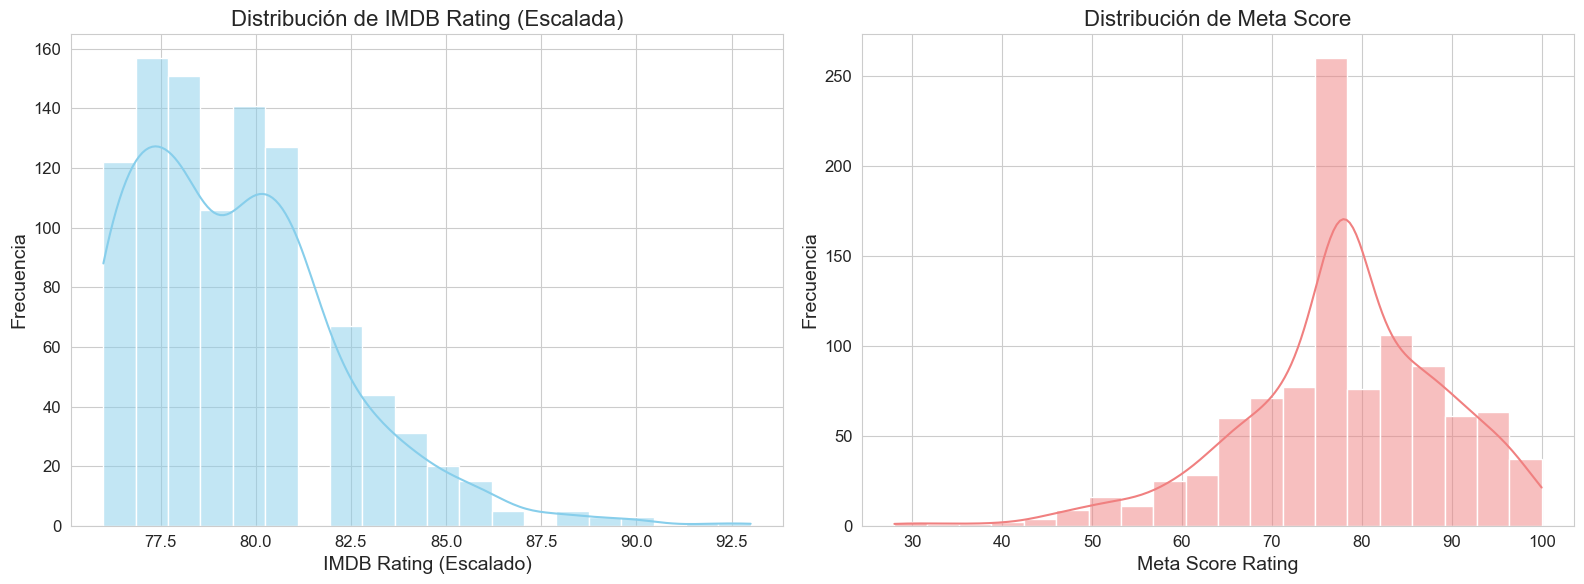

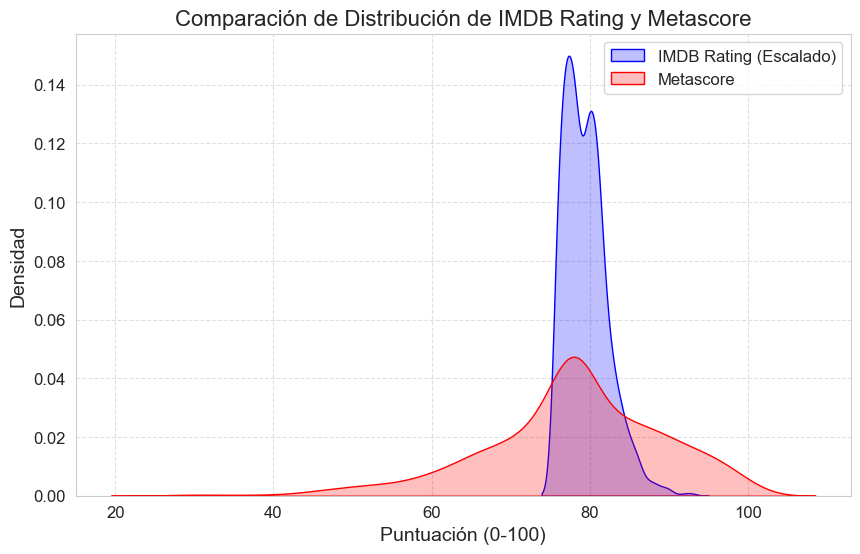

In [118]:
# PREGUNTA 2: DISTRIBUCIÓN DE CALIFICACIONES ENTRE IMDB Y META SCORE
print(f"--- Analizando la Distribución de los Ratings ---")


try:
    # QUERY
    sql_query_2_file_path = 'sql/rating_distribution.sql'
    with open(sql_query_2_file_path, 'r') as file:
        sql_q2 = file.read()
    df_distribution = pd.read_sql_query(sql_q2, conn)
    
    
    # Escalo IMDB rating para que sea comparable con Meta Score
    df_distribution['imdb_rating'] *= 10
    
    # VISUALIZACIÓN
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.histplot(df_distribution['imdb_rating'], kde=True, ax=axes[0], 
                 color='skyblue', bins=20)
    axes[0].set_title('Distribución de IMDB Rating (Escalada)')
    axes[0].set_xlabel('IMDB Rating (Escalado)')
    axes[0].set_ylabel("Frecuencia")
    
    sns.histplot(df_distribution['meta_score'], kde=True, ax=axes[1],
                 color='lightcoral', bins=20)
    axes[1].set_title('Distribución de Meta Score')
    axes[1].set_xlabel('Meta Score Rating')
    axes[1].set_ylabel('Frecuencia')

    plt.tight_layout()
    plt.show()

    # Gráfico de densidad combinado
    plt.figure(figsize=(10, 6))
    sns.kdeplot(df_distribution['imdb_rating'], label='IMDB Rating (Escalado)',
                color='blue', fill=True)
    sns.kdeplot(df_distribution['meta_score'], label='Metascore', color='red', fill=True)
    plt.title('Comparación de Distribución de IMDB Rating y Metascore')
    plt.xlabel('Puntuación (0-100)')
    plt.ylabel('Densidad')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
        
except FileNotFoundError:
    print(f"Error, el documento SQL no se encuentra en el path: {sql_query_2_file_path}")
except Exception as e:
    print(f"Error al ejecutar el comando SQL o visualizar la pregunta 2: {e}")

In [ ]:
# CIERRE DE LA CONEXIÓN CON LA BD
if 'conn' in locals() and conn is not None:
    try:
        conn.close()
        print(f"\nConexión a '{db_file}' cerrada.")
    except Exception as e:
        print(f"Error al cerrar la conexión: {e}")